# Intro

In this workbook,we will 
* create a user-product matrix
* Identify similar items
* Rank items for the recommendation


# Step 1: Import Python Libraries

Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity scores.

In [74]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Download And Read In Data

Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.

In [75]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')
!ls

# Change directory
import os
#os.chdir("content/sample_data/")

# Print out the current directory
#!pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
anscombe.json		      mnist_test.csv	     ratings.csv
california_housing_test.csv   mnist_train_small.csv  README.md
california_housing_train.csv  movies.csv


We created a custom data set to represent Tololi. 
We will use two ratings and products.

Now let's read in the rating data.

In [76]:
# Read in data
ratings = pd.read_csv('ratings.csv')

# Take a look at the data only for top values
ratings.head()

display(ratings)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


There are four columns in the ratings dataset, userID, productID, rating, and timestamp.

The dataset has over 100k records. To show dataset that has been read

In [77]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The 100k ratings are from 610 users on 9724 products. The rating has ten unique values from 0.5 to 5.

In [78]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Next, let's read in the products data to get the product names. 

The products dataset has productID, title, and genres.

In [79]:
# Read in data
movies = pd.read_csv('movies.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Product 1,Kitchen ware
1,2,Product 2,Food
2,3,Product 3,Drinks
3,4,Product 4,Clothes
4,5,Product 5,Toys


Using `movieID` as the matching key, we appended products information to the rating dataset and named it `df`. So now we have the product tile and product rating in the same dataset!


In [80]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
#df.head()

display(df)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Product 1,Kitchen ware
1,5,1,4.0,847434962,Product 1,Kitchen ware
2,7,1,4.5,1106635946,Product 1,Kitchen ware
3,15,1,2.5,1510577970,Product 1,Kitchen ware
4,17,1,4.5,1305696483,Product 1,Kitchen ware
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Product 9326,Kitchen ware
100832,610,160527,4.5,1479544998,Product 9331,Kitchen ware
100833,610,160836,3.0,1493844794,Product 9343,Drinks
100834,610,163937,3.5,1493848789,Product 9390,Toys


# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the products and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory. 

To do that, we first group the products by title, count the number of ratings, and keep only the products with greater than 100 ratings.

The average ratings for the products are calculated as well.

From the `.info()` output, we can see that there are 134 products left.

In [81]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check the information of the dataframe
agg_ratings_GT100.info()                              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 9715
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


Let's check what the most popular products and their ratings are.

In [82]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
2386,Product 315,4.164134,329
1975,Product 278,4.429022,317
1754,Product 258,4.197068,307
4559,Product 511,4.161290,279
1046,Product 1940,4.192446,278


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular products get higher ratings. 

The average rating distribution shows that most products in the dataset have an average rating of around 4.

The number of rating distribution shows that most products have less than 150 ratings.

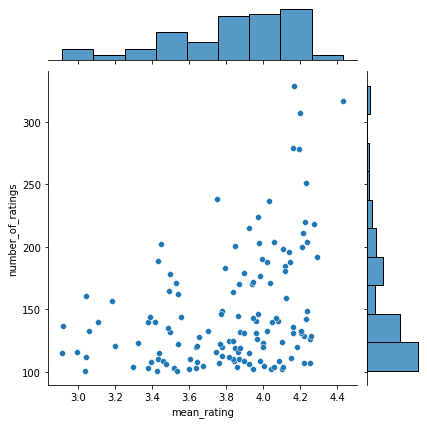

In [83]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

To keep only the 134 products with more than 100 ratings, we need to join the product with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the products with more than 100 ratings are included.

In [84]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


After filtering the product with over 100 ratings, we have 597 users that rated 134 products.

In [85]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are products, and the columns of the matrix are users. The value of the matrix is the user rating of the product if there is a rating. Otherwise, it shows 'NaN'.

In [86]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Product 1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
Product 10,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN
Product 1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN,4.5
Product 1184,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,2.5,3.0,3.5,NaN,NaN
Product 124,NaN,NaN,NaN,NaN,3.0,4.0,4.5,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,5.0,NaN,5.0,2.0,3.0,NaN


# Step 5: Data Normalization

In Step 5, we will normalize the data by subtracting the average rating of each product. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the product average rating get a negative value, and the ratings more than the products average rating get a positive value.

In [87]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Product 1,0.079070,NaN,NaN,NaN,0.079070,NaN,0.579070,NaN,NaN,NaN,...,0.07907,NaN,0.079070,-0.92093,0.079070,-1.420930,0.079070,-1.420930,-0.920930,1.07907
Product 10,NaN,NaN,NaN,NaN,NaN,-0.496212,NaN,-1.496212,NaN,NaN,...,NaN,-0.496212,NaN,NaN,NaN,NaN,NaN,0.503788,0.503788,NaN
Product 1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25431,NaN,NaN,NaN,NaN,0.254310,0.254310,0.254310,NaN,0.75431
Product 1184,-0.487879,NaN,NaN,-0.487879,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.512121,NaN,NaN,-0.987879,-0.487879,0.012121,NaN,NaN
Product 124,NaN,NaN,NaN,NaN,-0.845771,0.154229,0.654229,0.154229,NaN,NaN,...,NaN,0.154229,NaN,NaN,1.154229,NaN,1.154229,-1.845771,-0.845771,NaN


# Step 6: Calculate Similarity Score

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the item similarity matrix using Pearson correlation.

In [88]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,Product 1,Product 10,Product 1159,Product 1184,Product 124,Product 1268,Product 127,Product 1285,Product 1292,Product 1299,...,Product 916,Product 923,Product 924,Product 940,Product 958,Product 965,Product 970,Product 98,Product 99,Product 991
title,,,,,,,,,,,,,,,,,,,,,
Product 1,1.000000,-0.021409,0.240196,0.255308,0.191449,0.192972,0.157799,-0.044629,0.100546,0.069003,...,0.077476,0.187115,0.193898,0.173581,0.184023,0.231792,0.368229,0.028768,0.064991,0.052742
Product 10,-0.021409,1.000000,-0.142533,0.500313,0.166321,0.269828,0.199603,0.538349,-0.153921,-0.111950,...,0.113851,-0.218989,0.071295,0.070900,0.238270,0.200581,0.054729,0.060961,-0.353823,0.318386
Product 1159,0.240196,-0.142533,1.000000,0.115457,-0.114942,-0.001282,0.068261,-0.117726,-0.218503,0.149370,...,0.193815,0.186819,0.261640,0.191155,-0.039324,0.184006,-0.000865,0.076403,-0.084673,0.193372
Product 1184,0.255308,0.500313,0.115457,1.000000,0.292853,0.272213,0.303231,0.163674,0.257993,0.086877,...,0.107134,-0.086803,0.148479,0.266999,-0.225234,0.381178,0.234776,0.237511,0.049742,0.268411
Product 124,0.191449,0.166321,-0.114942,0.292853,1.000000,0.142660,0.379932,0.278480,0.364867,0.055915,...,0.148387,0.068396,0.547086,0.465033,0.027143,0.090708,0.096563,0.232201,0.153459,0.051625


Those who are interested in using cosine similarity can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [89]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

array([[ 1.        , -0.00818401,  0.08499063, ...,  0.01459722,
         0.02772935,  0.01652055],
       [-0.00818401,  1.        , -0.04429141, ...,  0.0360334 ,
        -0.04365197,  0.11383967],
       [ 0.08499063, -0.04429141,  1.        , ...,  0.0302877 ,
        -0.01899139,  0.09304082],
       ...,
       [ 0.01459722,  0.0360334 ,  0.0302877 , ...,  1.        ,
         0.09570597,  0.16977463],
       [ 0.02772935, -0.04365197, -0.01899139, ...,  0.09570597,
         1.        ,  0.01006508],
       [ 0.01652055,  0.11383967,  0.09304082, ...,  0.16977463,
         0.01006508,  1.        ]])

In the movie similarity matrix, the values range from -1 to 1, where -1 means opposite movie similarity and 1 means very high movie similarity.

# Step 7: Predict User's Rating For One Movie

In step 7, we will predict a user's rating for one product. Let's use user 1 and the product as an example.

The prediction follows the process below:
1. Create a list of the products that user 1 has bought and rated.
2. Rank the similarities between the movies user 1 rated
3. Select top n products with highest similarity scores.
4. Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1.

Now let's implement the process using Python. 

Firstly, we removed all the products that have a missing rating for user 1, and sorted the products by the ratings.

In [90]:
# Pick a user ID
picked_userid = 10

# Pick a movie
picked_movie = 'Product 15'

# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'ratings'})

picked_userid_watched.head()

,title,10
0,Product 5918,1.137931
1,Product 3195,0.632353
2,Product 6711,0.261745
3,Product 507,0.207650
4,Product 2675,0.061765
